In [1]:
pip install tensorflow numpy matplotlib scikit-learn

In [2]:
import numpy as np
import pandas as pd
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import files
uploaded = files.upload()

Saving preprocessed_comments.csv to preprocessed_comments.csv


In [4]:
# Step 1: Load and Preprocess Data
df = pd.read_csv('preprocessed_comments.csv', encoding='latin1')
df.head()

,text,classification
0,people freak,1
1,ben shapiro correct,0
2,wish ben moment coroner would pull dude nut he...,1
3,smart one room wrong room,0
4,would never say someone physical threat cowardly,1


In [5]:
# Assuming the CSV has columns 'text' and 'classification'
texts = df['text'].astype(str).values
labels = df['classification'].values

In [6]:
# Preprocess text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
    return text

In [7]:
texts = [preprocess_text(t) for t in texts]

In [8]:
# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Tokenize and pad the text data
max_words = 10000  # Maximum vocabulary size
max_len = 100      # Maximum sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
pre_padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='pre', truncating='pre')  # Changed to 'pre'

In [9]:
# Split data into training and testing sets
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(
    pre_padded_sequences, labels, test_size=0.33, random_state=42
)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_pre), y=y_train_pre)
class_weights = dict(enumerate(class_weights))

In [10]:
# Step 2: Build the Improved LSTM Model
lstm_model_pre = Sequential([
    Embedding(input_dim=max_words, output_dim=64),
    LSTM(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
lstm_model_pre.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])


In [11]:
# Step 3: Train the Model
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_pre = lstm_model_pre.fit(
    X_train_pre, y_train_pre,
    epochs=20,
    batch_size=64,
    validation_data=(X_test_pre, y_test_pre),
    callbacks=[early_stopping],
    class_weight=class_weights
)


Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 35s 189ms/step - accuracy: 0.6140 - loss: 0.6658 - val_accuracy: 0.4752 - val_loss: 0.6957
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 39s 178ms/step - accuracy: 0.8165 - loss: 0.4104 - val_accuracy: 0.7234 - val_loss: 0.5446
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 27s 177ms/step - accuracy: 0.9009 - loss: 0.2669 - val_accuracy: 0.8166 - val_loss: 0.3995
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.9290 - loss: 0.1975 - val_accuracy: 0.8155 - val_loss: 0.4714
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 42s 181ms/step - accuracy: 0.9484 - loss: 0.1472 - val_accuracy: 0.8213 - val_loss: 0.5072
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 46s 214ms/step - accuracy: 0.9586 - loss: 0.1142 - val_accuracy: 0.8178 - val_loss: 0.5837


In [12]:
# Step 4: Evaluate the Model
loss, accuracy = lstm_model_pre.evaluate(X_test_pre, y_test_pre)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Get predictions
y_pred_pre = lstm_model_pre.predict(X_test_pre)
y_pred_pre_class = (y_pred_pre > 0.5).astype('int32')

152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.8145 - loss: 0.4030
Test Loss: 0.3995, Test Accuracy: 0.8166
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step


In [13]:
# Step 5: Evaluate Metrics
f1 = f1_score(y_test_pre, y_pred_pre_class)
precision = precision_score(y_test_pre, y_pred_pre_class)
recall = recall_score(y_test_pre, y_pred_pre_class)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

F1 Score: 0.8601
Precision: 0.8271
Recall: 0.8958


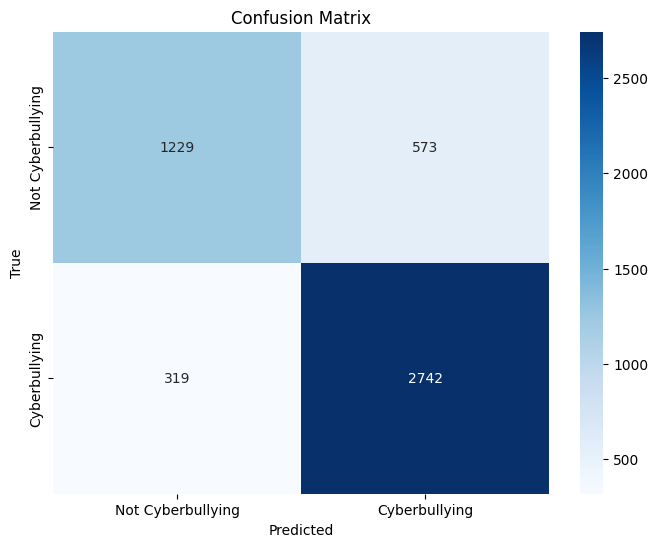

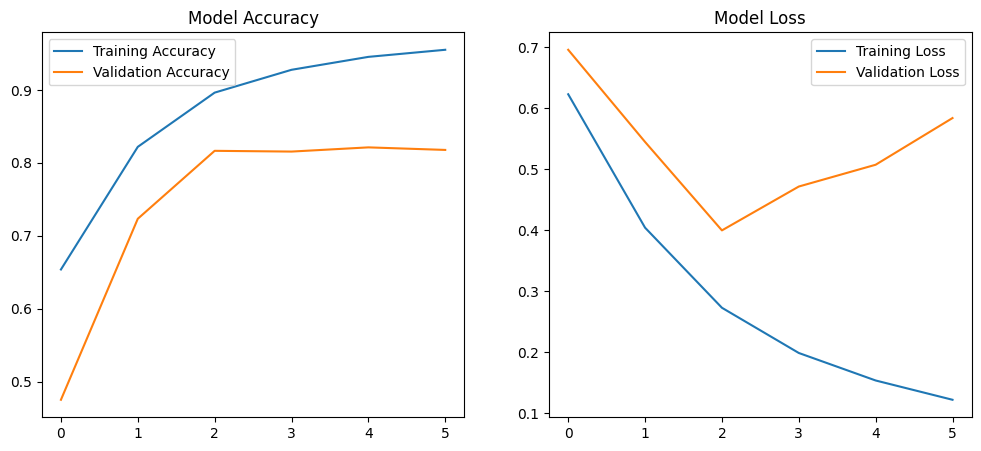

In [14]:
# Confusion Matrix
conf_matrix_pre = confusion_matrix(y_test_pre, y_pred_pre_class)
class_names = ['Not Cyberbullying', 'Cyberbullying']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_pre, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Step 6: Visualize Training History
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_pre.history['accuracy'], label='Training Accuracy')
plt.plot(history_pre.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_pre.history['loss'], label='Training Loss')
plt.plot(history_pre.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

In [15]:
lstm_model_pre.save('lstm_model.h5')
files.download('lstm_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>